# Introduction
This report showcases some geospatial analyses that are possible with fuel stations data. The analyses are a preliminary set of possibilities to explore the concept of 'fuel station value' for Z. Because we're still uncertain what 'value' might mean / signify to the client, I've cast the net for potential analyses quite wide. In particular, I've used studies from urban data science as inspiration. Some resources I've consulted include:
- [Talk on Urban Data Science by Dr. Cecilia Mascolo](https://www.youtube.com/watch?v=eNpdvzORWVc&t=2162s)
- [Understanding Traffic with Open Data by researchers at Oxford Internet Institute](https://www.youtube.com/watch?v=0GM0sEvQ2-M)
- [Geoff Boening's blog - especially his package OSMnx](https://geoffboeing.com/2016/11/osmnx-python-street-networks/)
- [Proximity and accessibility analyses with Pandana](https://github.com/gboeing/urban-data-science/blob/master/20-Accessibility-Walkability/pandana-accessibility-demo-full.ipynb)



# Introduction to Spatial data

## What is spatial data?

## Tools for spatial data analysis
Tool | What does it do?
--- | ---
Open Street Maps (OSM) | [An open, collaborative map of the world](https://en.wikipedia.org/wiki/OpenStreetMap). Anyone can edit and get data.  
Overpass | [An API](https://wiki.openstreetmap.org/wiki/Overpass_API) to get data from OSM.
OSMNX | A python package that can analyse streets and roads with network algorithms.


## Techniques to derive insight from spatial data



# Get Spatial data

In [1]:
# Import some packages
import overpy as op
import pandas as pd
import json
import requests
import osmnx as ox 
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import utils.network_analysis as na

%matplotlib inline
ox.config(log_console=True, use_cache=True)
pd.set_option('display.max_columns', 200)

## Set bounding box
Can use the visual tool [here](http://boundingbox.klokantech.com/) to get the bounding box coordinates we're interested in. 

In [2]:
# Define bounding box (W, S, E, N) for the area of Wellington we're interested in
bbox = [174.5813,-41.4552,175.0722,-41.1527]

# Separate out the bounding box list into 4 vertices. 
south = bbox[1]
west = bbox[0]

# Rechts oben
north = bbox[3]
east = bbox[2]

## Create Query
The following section creates a query to get fuel station data from Open Street Maps. The tags list can also be amended to get other amenities. The full list is [here](https://wiki.openstreetmap.org/wiki/Key:amenity). For example, we can easily get data for cafes and restaurants by adding these to the tags list.  

The Overpass API query is not very easy to read but the main components are: 
- The bounding box: the area where we want the search performed. 
    - In this example, I've chosen a bounding around an arbitrary area of Greater Wellington which includes Wellington City some of the closer regions (e.g. Lower Hutt).  
- Data Primitives: ways, nodes, tags, relations.
    - Queries by tags within the main entities: the *types* of ways and nodes. Here we only retrieve ways and nodes that have been tagged as fuel stations.
    
More information about the entities of Open Street Maps can be found [here](https://en.wikipedia.org/wiki/OpenStreetMap#Operation). 

In [3]:
# What types of entitities do we want to get? Currently restricted to amenities
tags = ['fuel']
objects = ['node', 'way'] # like way, node, relation

In [4]:
# Generate the query string
compactOverpassQLstring = '[out:json][timeout:60];('
for tag in tags:
    for obj in objects:
        compactOverpassQLstring += '%s["amenity"="%s"](%s,%s,%s,%s);' % (obj, tag, south, west, north, east)
compactOverpassQLstring += ');out body;>;out skel qt;'    
print compactOverpassQLstring

[out:json][timeout:60];(node["amenity"="fuel"](-41.4552,174.5813,-41.1527,175.0722);way["amenity"="fuel"](-41.4552,174.5813,-41.1527,175.0722););out body;>;out skel qt;


## Getting data from Overpass 
Getting data from Open Street Map is fairly simple via the Overpass API. All you need to do is construct the search query and reshape the result JSON into your data structure of choice. I've reshaped the data as a Pandas dataframe - basically a table with columns that contain metadata about each fuel station identified by the search query. 

In [5]:
# Request data from Overpass
osmrequest = {'data': compactOverpassQLstring}
osmurl = 'http://overpass-api.de/api/interpreter'
# Ask the API
osm = requests.get(osmurl, params=osmrequest)

# Convert the results to JSON and get the requested data from the 'elements' key
# The other keys in osm.json() are metadata guff like 'generator', 'version' of API etc. 
osmdata = osm.json()
osmdata = osmdata['elements']

In [6]:
# Convert JSON output to pandas dataframe
for dct in osmdata:
    if dct.has_key('tags'):
        for key, val in dct['tags'].iteritems():
            dct[key] = val
        del dct['tags']
    else:
        pass
osmdf = pd.DataFrame(osmdata)
osmdf.head()

,addr:city,addr:housenumber,addr:postcode,addr:street,addr:suburb,amenity,amenity_1,brand,building,building:levels,diesel,fuel:HGV_diesel,fuel:diesel,fuel:electric,fuel:lpg,fuel:octane_91,fuel:octane_95,fuel:octane_98,id,lat,lon,name,name:en,nodes,opening_hours,operator,ref:linz:address_id,type,wheelchair
0,NaN,NaN,NaN,NaN,NaN,fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203840709,-41.175811,174.825616,NaN,NaN,NaN,NaN,NaN,NaN,node,NaN
1,NaN,NaN,NaN,NaN,NaN,fuel,NaN,Mobil,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206201048,-41.222110,174.807036,Mobil Johnsonville,NaN,NaN,NaN,NaN,NaN,node,NaN
2,NaN,NaN,NaN,NaN,NaN,fuel,NaN,BP,NaN,NaN,NaN,NaN,yes,NaN,yes,yes,no,yes,206201049,-41.225857,174.807492,BP Johnsonville,NaN,NaN,NaN,NaN,NaN,node,NaN
3,NaN,NaN,NaN,NaN,NaN,fuel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300202137,-41.306680,174.763337,NaN,NaN,NaN,NaN,Caltex,NaN,node,NaN
4,NaN,NaN,NaN,NaN,NaN,fuel,NaN,BP,NaN,NaN,NaN,yes,yes,NaN,NaN,yes,yes,NaN,307348809,-41.232089,174.837406,BP Hutt Road,NaN,NaN,NaN,NaN,NaN,node,NaN


## Data specifics?

In [7]:
# Isolate a subset of useful attributes per fuel station
sub_df = (osmdf[['id', 'lat', 'lon', 'name', 'operator', 'brand', 'type']]
          .sort_values(['lat', 'lon'])
          .reset_index()
          .drop(columns='index'))
sub_df.head(5)

,id,lat,lon,name,operator,brand,type
0,2845230323,-41.325288,174.810883,NaN,NaN,NaN,node
1,2845230324,-41.325284,174.811057,NaN,NaN,NaN,node
2,2845230322,-41.325275,174.810774,NaN,NaN,NaN,node
3,2845230321,-41.325200,174.810729,NaN,NaN,NaN,node
4,5821475056,-41.325128,174.810920,Z Broadway,NaN,Z,node


# Data for analysis with Z Stations

## Get Z Stations
We can query the Wellington fuel stations dataset to only get those that are associated with Z. The query returns 13 Z stations within the search region. From a cursory glance at the named Z stations and [the list from the website](https://bit.ly/2KEqu5m), we can see that there is considerable parity. We're missing Z Constable St but I believe the rest are there. Despite the close parity however, there are some issues with the data:
- Inconsistency between the operator and brand attributes. 
- No geolocation for some stations. 

![](assets/ways_without_geoloc.png)

The key problem with the data is that a significant portion of the stations don't have location coordinates. This problem, unfortunately stems from the fact that OSM has two main types of topological entities: ways and nodes. Depending on how a user marks out the location of a fuel station, the entity can be either a way or a node. 

- If the station is marked with a single point, the entity is a node with a clear geolocation. 
- If the station's perimeter / main building is traced out as a polygon, the entity is a way with no clear geolocation.  

In [8]:
# Show all Z stations labelled as a node. i.e. with geolocation 
z_stations = (sub_df.query('((brand == "Z")|(operator == "Z")) & (type == "node")')
              .reset_index()
              .drop(columns='index'))
z_stations

,id,lat,lon,name,operator,brand,type
0,5821475056,-41.325128,174.810920,Z Broadway,NaN,Z,node
1,3120151445,-41.320054,174.794407,Z Kilbirnie,NaN,Z,node
2,5821475059,-41.314924,174.813972,Z Miramar,NaN,Z,node
3,5821475061,-41.313163,174.781812,Z Constable Street,NaN,Z,node
4,5821475058,-41.297146,174.776556,Z Taranaki Street,NaN,Z,node
5,5544110098,-41.294501,174.774397,Z Vivian St,NaN,Z,node
6,5821475063,-41.281636,174.778417,Z Harbour City,NaN,Z,node
7,5821475060,-41.256020,174.765535,Z Crofton Downs,NaN,Z,node
8,2206248455,-41.236226,174.906171,Z Seaview,NaN,Z,node
9,331132009,-41.226300,174.806795,Z Johnsonville,NaN,Z,node


## Get routes between two Z Stations

The package, OSMnx (a portmanteau acronym of Open Street Maps, OSM, and NetworkX, nx), is a great package for doing network anlysis with street data. A trivial description of the underlying representation used by this package is a reduction of streets and roads to edges. The vertices that connect these edges become the nodes. The position of the nodes and the trajectory of the edges are further described with geolocation coordinates. Once I find out more about the technical aspects, I'll write it down in a separate section. 

With the OSMnx package, we can superimpose entities with geolocation on the spatial network. Once we've done this, we can find a path connecting any two nodes. Because of the representation constraints, we don't find the route between the 2 specific entity coordinates (unlike Google Maps) - instead, we find the path between two nodes closest to the entities. 

The route between the nodes, uses the edges (or, streets and roads) of the spatial network. The algorithm is an analogue of the [typical shortest path analyses done in network science](https://en.wikipedia.org/wiki/Shortest_path_problem). In the spatial network, the path length can be equated to distance. 

The following example looks at the distance and route between two Z stations: Z Kilbernie and Z Vivian St. The red line in the figure is the shortest route that connects the two stations. From the street shapes, you can see that the route is wending it's way around Evans Bay, Basin Reserve before entering the central city street grid. This route has a distance of 4.6 km - a value that corresponds quite closely to that given by [Google Maps](https://bit.ly/2Mvjr0L). 

In [9]:
# Get street network with a 5km radius around Z Kilbirnie
origin_point = tuple(z_stations.query('name == "Z Kilbirnie"')[['lat', 'lon']].values[0])
destination_point = tuple(z_stations.query('name == "Z Vivian St"')[['lat', 'lon']].values[0])
G = ox.graph_from_point(origin_point, distance=10000, distance_type='network', network_type='drive')

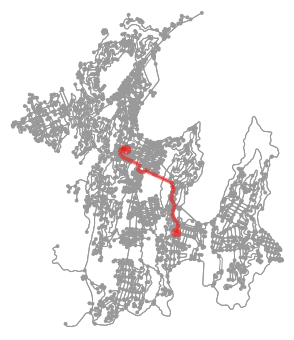

In [10]:
# Plot the route from the closest nodes to Z Kilbirnie and Z Vivian St
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)

nx.shortest_path_length(G, origin_node, destination_node, weight='length')
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
str(route)
fig, ax = ox.plot_graph_route(G, route)

In [11]:
# Distance
print "Shortest distance between \
Z Kilbirnie and Z Vivian St is {} m".format(nx.shortest_path_length(G, 
                                                                    origin_node, 
                                                                    destination_node, 
                                                                    weight='length'))

Shortest distance between Z Kilbirnie and Z Vivian St is 4577.443 m


 ## Get street network for Wellington

In [12]:
# Get street network for Wellington. 
# Can use place name to get the street network. 
# place = 'Wellington City, New Zealand'
# F = ox.graph_from_place(place, network_type='drive_service')

# A better option is to use the bounding box that we've already used to get fuel stations.
H = ox.graph_from_bbox(north, south, east, west, network_type='drive_service')

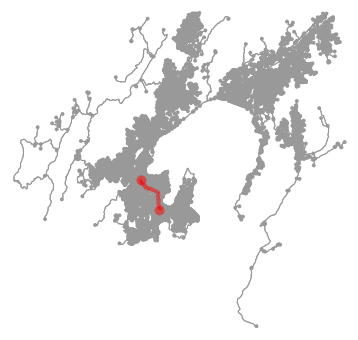

In [13]:
# Plot the route between Z Kilbinie and Z Vivian St on this larger area network
nx.shortest_path_length(H, origin_node, destination_node, weight='length')
route = nx.shortest_path(H, origin_node, destination_node, weight='length')
str(route)
fig, ax = ox.plot_graph_route(H, route)

In [14]:
nx.shortest_path_length(H, origin_node, destination_node, weight='length')

4386.844999999998

## Get distances between all Z stations

In [15]:
# Replace IDs with fuel station names to get final dataframe
z_stations_pairwise = na.get_pairwise_distances(z_stations, H)
z_station_names = z_stations[['id', 'name']]
z_pairwise_final = (pd.merge(pd.merge(z_stations_pairwise, z_station_names, left_on='from', right_on='id'),
                             z_station_names, left_on='to', right_on='id')
                    .drop(columns=['from', 'to'])
                    .rename(columns={'name_x': 'from', 'name_y': 'to',
                                     'id_x': 'id_from', 'id_y': 'id_to'})
                    .query('distance > 0.0'))

z_pairwise_final.head(5)

,distance,id_from,from,id_to,to
1,2822.644,3120151445,Z Kilbirnie,5821475056,Z Broadway
2,1332.762,5821475059,Z Miramar,5821475056,Z Broadway
3,4002.103,5821475061,Z Constable Street,5821475056,Z Broadway
4,5644.063,5821475058,Z Taranaki Street,5821475056,Z Broadway
5,5744.885,5544110098,Z Vivian St,5821475056,Z Broadway


# Analysis: Average distance between two closest Z stations in Wellington

In [17]:
# Ordered list of distance to the closest Z station
closest_z_stations = z_pairwise_final.groupby('from')['distance'].agg('min')
closest_z_stations.sort_values()

from
Z Vivian St            436.455
Z Taranaki Street      438.123
Z Broadway            1332.762
Z Miramar             1332.762
Z Harbour City        1710.964
Z Constable Street    1858.682
Z Kilbirnie           2111.346
Z Petone              2227.071
Z VIC Corner          2336.533
Z High Street         2356.524
Z Hutt Road           2836.554
Z Seaview             3755.743
Z Crofton Downs       5270.263
Z Johnsonville        5767.462
Name: distance, dtype: float64

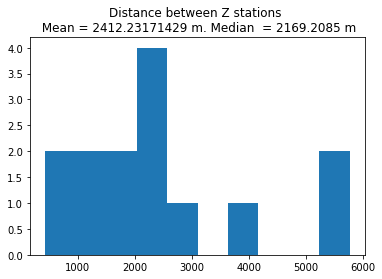

In [18]:
# Plot the distances
plt.hist(closest_z_stations);
plt.title('Distance between Z stations \n Mean = {} m. Median  = {} m'.format(closest_z_stations.mean(), 
                                                                             closest_z_stations.median()));

# Analysis: Network Analysis of Z stations
## Visualise Z stations

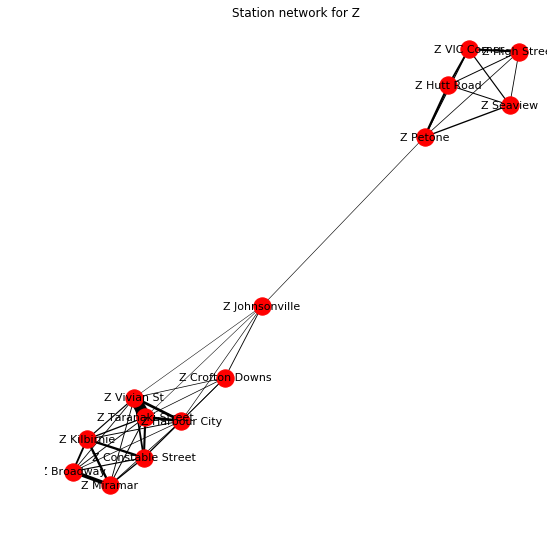

In [26]:
g = na.visualise_station_network(pairwise_df=z_pairwise_final)

## Network properties

In [27]:
# Calculate unweighted degree (# connections for each Z station)
(pd.DataFrame(list(g.degree()))
 .rename(columns={0: 'station', 1: 'degree'})
 .sort_values('degree', ascending=False))

,station,degree
0,Z Harbour City,8
9,Z Vivian St,8
11,Z Taranaki Street,8
6,Z Constable Street,7
5,Z Miramar,6
8,Z Broadway,6
10,Z Kilbirnie,6
2,Z Crofton Downs,5
4,Z Petone,5
7,Z Johnsonville,5


# Comparative Analysis: Z vs. BP stations

In [28]:
bp_stations = (sub_df.query('((brand == "BP")|(operator == "BP")) & (type == "node")')
              .reset_index()
              .drop(columns='index'))
bp_stations_pairwise = na.get_pairwise_distances(bp_stations, H)


In [30]:
bp_station_names = bp_stations[['id', 'name']]
bp_pairwise_final = (pd.merge(pd.merge(bp_stations_pairwise, bp_station_names, left_on='from', right_on='id'),
                          bp_station_names, left_on='to', right_on='id')
                    .drop(columns=['from', 'to'])
                    .rename(columns={'name_x': 'from', 'name_y': 'to',
                                     'id_x': 'id_from', 'id_y': 'id_to'})
                    .query('distance > 0.0'))

bp_pairwise_final.head(5)

,distance,id_from,from,id_to,to
1,3154.860,5828326865,BP Brooklyn,2384031154,BP Berhampore
2,1977.691,5828326863,BP Adelaide Road,2384031154,BP Berhampore
3,3589.235,5828326864,BP Roadmaster,2384031154,BP Berhampore
4,8616.122,995646591,BP Karori,2384031154,BP Berhampore
5,25481.533,3599864283,BP Wainuiomata,2384031154,BP Berhampore


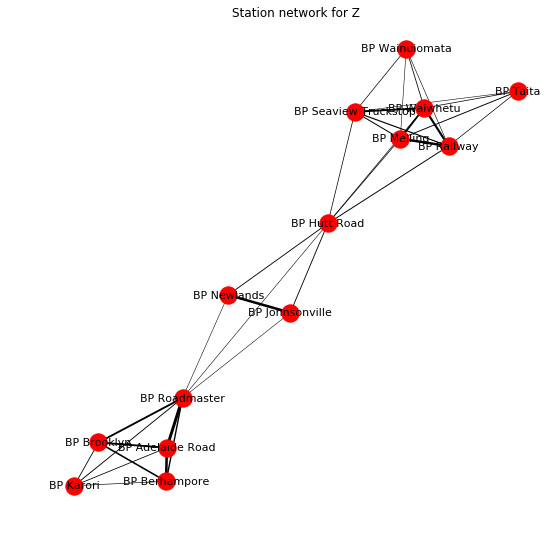

In [31]:
h = na.visualise_station_network(bp_pairwise_final)

In [32]:
# Calculate unweighted degree (# connections for each Z station)
(pd.DataFrame(list(h.degree()))
 .rename(columns={0: 'station', 1: 'degree'})
 .sort_values('degree', ascending=False))

,station,degree
0,BP Hutt Road,7
12,BP Roadmaster,7
3,BP Melling,6
4,BP Railway,6
8,BP Seaview Truckstop,6
10,BP Waiwhetu,6
1,BP Berhampore,4
2,BP Wainuiomata,4
7,BP Brooklyn,4
9,BP Adelaide Road,4
